In [1]:
!pip install "ultralytics==8.0.5"


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from ultralytics import YOLO

MODEL_NAME = "yolov8n-seg"

model = YOLO(f'{MODEL_NAME}.pt')

In [3]:
label_map = model.model.names

IMAGE_PATH = "../data/image/coco_bike.jpg"
results = model(IMAGE_PATH, return_outputs=True)

Ultralytics YOLOv8.0.5 🚀 Python-3.8.10 torch-1.13.1+cpu CPU
Fusing layers... 
YOLOv8n-seg summary: 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs


In [4]:
image_result = next(results)

boxes = image_result["det"]
masks = image_result["segment"]

False


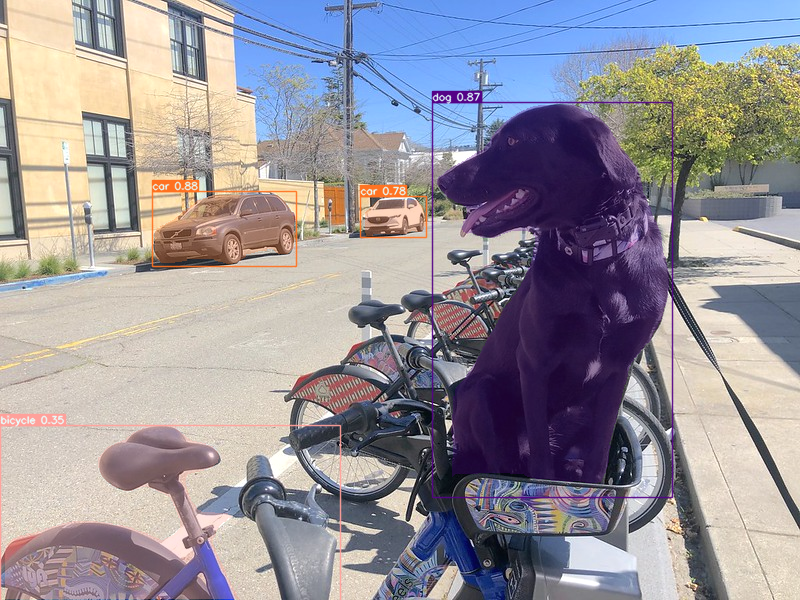

In [6]:
from typing import Tuple
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, mask:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    image_with_mask = img.copy()
    cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
    img = cv2.addWeighted(img, 0.7, image_with_mask, 0.3, 1)
    return img


def draw_boxes_and_masks(boxes:np.ndarray, masks:np.ndarray, source_image:np.ndarray):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
    Returns:
        
    """
    for ((*xyxy, conf, cls), mask) in zip(boxes, masks):
        label = f'{label_map[int(cls)]} {conf:.2f}'
        source_image = plot_one_box(xyxy, mask, source_image, label=label, color=colors(int(cls)), line_thickness=1)
    return source_image


img = np.array(Image.open(IMAGE_PATH))
img_with_boxes = draw_boxes_and_masks(boxes, masks, img.copy())
Image.fromarray(img_with_boxes)

In [7]:
from pathlib import Path

model_path = Path(f"{MODEL_NAME}_openvino_model/{MODEL_NAME}.xml")
if not model_path.exists():
    model.export(format="openvino", dynamic=True, half=False)

In [8]:
from openvino.runtime import Core, Model

core = Core()
ov_model = core.read_model(model_path)
device = "CPU"  # GPU
if device != "CPU":
    ov_model.reshape({0: [1, 3, 640, 640]})
compiled_model = core.compile_model(ov_model, device)

In [9]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [15]:
def postprocess(preds_boxes:np.ndarray, preds_masks:np.ndarray, input_hw:Tuple[int, int], orig_img:np.ndarray, min_conf_threshold:float = 0.25, nms_iou_threshold:float = 0.7, agnosting_nms:bool = False, max_detections:int = 300, retina_mask=False):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        preds (np.ndarray): model output predictions
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    
    preds = ops.non_max_suppression(
        torch.from_numpy(preds_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        agnostic=agnosting_nms,
        max_det=max_detections,
        nm=32
    )
    all_boxes = []
    all_masks = []
    proto = torch.from_numpy(preds_masks)

    for i, pred in enumerate(preds):
        print(pred.shape)
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            all_boxes.append([])  # save empty boxes
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)  # HWC
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        all_boxes.append(pred[:, :6])
        all_masks.append(segments)
    return all_boxes, all_masks

torch.Size([4, 38])


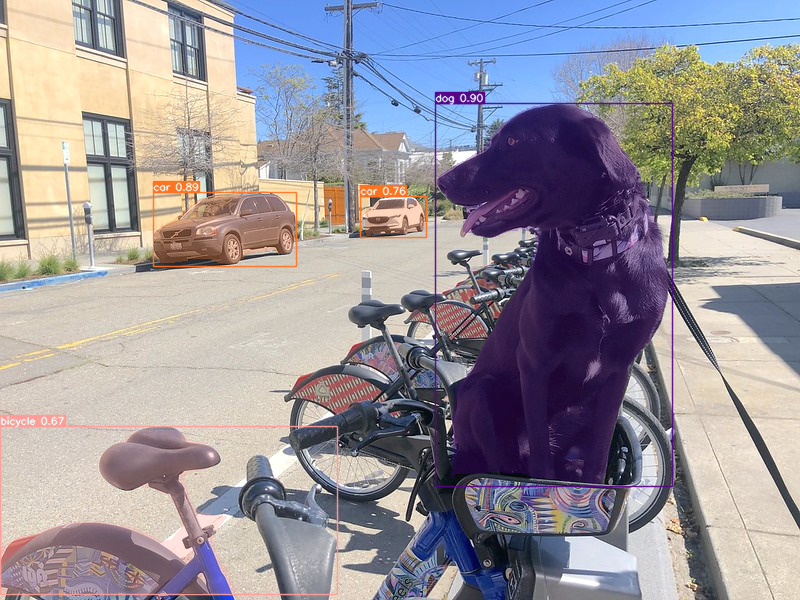

In [16]:
def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_boxes = model.output(0)
    output_masks = model.output(1)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    results = model(input_tensor)

    input_hw = input_tensor.shape[2:]
    detections = postprocess(results[output_boxes], results[output_masks], input_hw, image)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
boxes, masks = detect(input_image, compiled_model)
image_with_boxes = draw_boxes_and_masks(boxes[0], masks[0], input_image)

Image.fromarray(image_with_boxes)

In [17]:
import sys
from zipfile import ZipFile

sys.path.append("../utils")
from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('./datasets')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(OUT_DIR / 'coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(OUT_DIR / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'datasets/val2017.zip' already exists.
'datasets/coco2017labels-segments.zip' already exists.


In [18]:
from ultralytics.yolo.utils import DEFAULT_CONFIG
from ultralytics.yolo.configs import get_config
args = get_config(config=DEFAULT_CONFIG)
args.data = "coco.yml"

validator = model.ValidatorClass(args)

In [19]:
data_loader = validator.get_dataloader("datasets/coco", 1)

val: Scanning datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


In [20]:
from tqdm.notebook import tqdm
from ultralytics.yolo.utils.metrics import ConfusionMatrix

validator.is_coco = True
validator.class_map = ops.coco80_to_coco91_class()
validator.names = model.model.names
validator.metrics.names = validator.names
validator.nc = model.model.model[-1].nc

In [27]:
def test(model:Model, core:Core, data_loader:torch.utils.data.DataLoader, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.plot_masks = []
    validator.jdict = []
    validator.nm = 32
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    validator.process = ops.process_mask
    validator.batch_i = 1
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    output_boxes = compiled_model.output(0)
    output_masks = compiled_model.output(1)
    for batch_i, batch in enumerate(data_loader):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        res = compiled_model(batch["img"])
        preds = [torch.from_numpy(res[output_boxes]), [torch.from_numpy(res[output_masks])]]
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))

In [28]:
fp_stats = test(ov_model, core, tqdm(data_loader))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [30]:
def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    print("Masks")
    mp, mr, map50, mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))

In [31]:
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

Boxes
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.622        0.48       0.517       0.364
Masks
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.621       0.456       0.491       0.305


In [32]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [33]:
quantized_model = nncf.quantize(
    ov_model, 
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=nncf.IgnoredScope(
        types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
        names=["/model.22/dfl/conv/Conv",           # in the post-processing subgraph
               "/model.22/Add",
               "/model.22/Add_1",
               "/model.22/Add_2",
               "/model.22/Add_3",
               "/model.22/Add_4",
               "/model.22/Add_5",
               "/model.22/Add_6",
               "/model.22/Add_7",
               "/model.22/Add_8",
               "/model.22/Add_9",
               "/model.22/Add_10"]
    ))

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,F

In [34]:
from openvino.runtime import serialize
int8_model_path = Path(f'{MODEL_NAME}_openvino_int8_model/{MODEL_NAME}.xml')
print(f"Quantized model will be saved to {int8_model_path}")
serialize(quantized_model, str(int8_model_path))

Quantized model will be saved to yolov8n-seg_openvino_int8_model/yolov8n-seg.xml


torch.Size([4, 38])


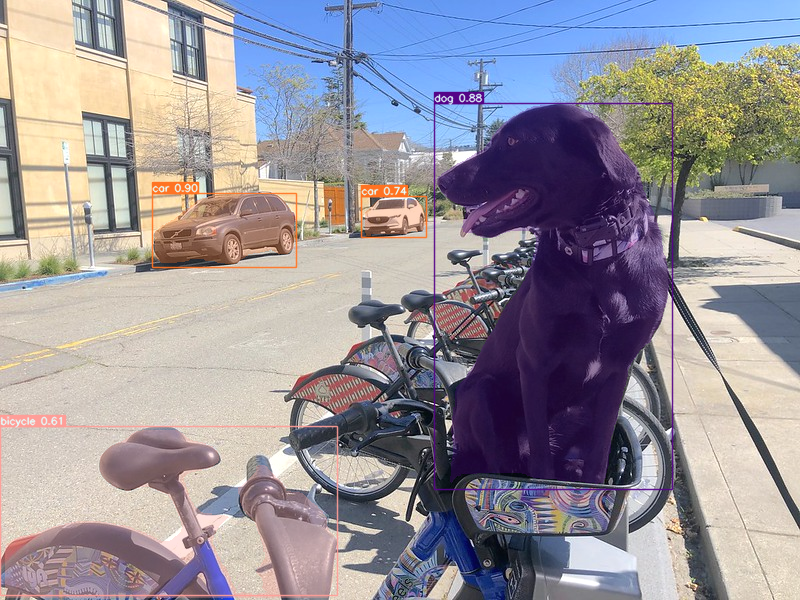

In [37]:
if device != "CPU":
    quantized_model.reshape({0, [1, 3, 640, 640]})
quantized_compiled_model = core.compile_model(quantized_model, device)
input_image = np.array(Image.open(IMAGE_PATH))
boxes, masks = detect(input_image, quantized_compiled_model)
image_with_boxes = draw_boxes_and_masks(boxes[0], masks[0], input_image)

Image.fromarray(image_with_boxes)

In [38]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m $model_path -d CPU -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 41.02 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [?,116,?]
[ INFO ]     output1 (node: output1) : f32 / [...] / [?,32,1..,1..]
[Step 5/11] Resizing model to match image sizes and given batch
[ 

In [39]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $int8_model_path -d CPU -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 66.90 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,116,3..]
[ INFO ]     output1 (node: output1) : f32 / [...] / [1,32,1..,1..]
[Step 5/11] Resizing model to match image sizes and given batch


In [40]:
int8_stats = test(quantized_model, core, tqdm(data_loader))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [41]:
print("FP32 model accuracy")
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_stats, validator.seen, validator.nt_per_class.sum())

FP32 model accuracy
Boxes
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.622        0.48       0.517       0.364
Masks
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.621       0.456       0.491       0.305
INT8 model accuracy
Boxes
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335        0.61       0.478       0.513       0.361
Masks
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.607       0.456       0.486       0.302
